# EE675 Final Project Code Release
## Alireza Habibzadeh


Some parts of the code for loading the dataset and showing electrode locations adopted from the Brain Tree Bank quickstart notebook which can be found here: https://braintreebank.dev


**Note: Some results in the report are from a run with num_electrodes set to 999 (essentially using all the electrodes) but the current results in the notebook are for num_electrodes = 30 for debug purposes, as running it with all the electrodes takes hours. Electrodes are chosen randomly.**

In [ ]:
import h5py
import os
import json
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy import signal, stats
from google.colab import drive
from concurrent.futures import ProcessPoolExecutor
from functools import partial
from tqdm.auto import tqdm

## Loading data

In [ ]:
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

root_dir = "/content/drive/MyDrive/braintreebank_data/"

sub_id = 3
trial_id = 0
random.seed(675)
num_electrodes = 30

# Features

FEATURE_CATEGORIES = {
    'Visual': [
        'mean_pixel_brightness',
        'max_global_magnitude',
        'max_global_angle',
        'max_vector_magnitude',
        'max_vector_angle',
        'face_num'
    ],
    'Auditory': [
        'rms',
        'pitch',
        'delta_rms',
        'delta_pitch'
    ],
    'Language': [
        'pos-verb',
        'pos-noun',
        'bin_head',
        'gpt2_surprisal',
        'word_diff',
        'word_length',
        'idx_in_sentence'
    ]
}

# Flatten list for loading from the csv
ALL_REQUESTED_FEATURES = []
for cat_list in FEATURE_CATEGORIES.values():
    ALL_REQUESTED_FEATURES.extend(cat_list)

metadata_file_json = os.path.join(root_dir, f'subject_metadata/sub_{sub_id}_trial{trial_id:03}_metadata.json')
metadata_file_csv = os.path.join(root_dir, f'subject_metadata/sub_{sub_id}_trial{trial_id:03}_metadata.csv')

movie_id = None
if os.path.exists(metadata_file_json):
    with open(metadata_file_json, 'r') as f:
        meta_dict = json.load(f)
        movie_id = meta_dict.get('filename', None)
elif os.path.exists(metadata_file_csv):
    meta_df = pd.read_csv(metadata_file_csv)
    if 'filename' in meta_df.columns:
        movie_id = meta_df.iloc[0]['filename']

print(f"Movie ID: {movie_id}")

neural_file = os.path.join(f"{root_dir}/all_subject_data/", f'sub_{sub_id}_trial{trial_id:03}.h5')
trigger_file = os.path.join(root_dir, f'subject_timings/sub_{sub_id}_trial{trial_id:03}_timings.csv')
transcript_file = os.path.join(root_dir, f'transcripts/{movie_id}/features.csv')

Mounted at /content/drive
Movie ID: cars-2


## Aligning

In [ ]:
words_df = pd.read_csv(transcript_file)
if 'Unnamed: 0' in words_df.columns:
    words_df = words_df.set_index('Unnamed: 0')
words_df = words_df.dropna().reset_index(drop=True)

trigs_df = pd.read_csv(trigger_file)
fs = 2048
trig_times = trigs_df['movie_time'].values
words_df = words_df[words_df['start'] <= trig_times[-1]].copy().reset_index(drop=True)

# Alignment (based on https://braintreebank.dev/data/quickstart.ipynb)
idx_insert = np.searchsorted(trig_times, words_df['start'].values)
idx_insert = np.clip(idx_insert, 0, len(trig_times) - 1)
diff_curr = np.abs(trig_times[idx_insert] - words_df['start'].values)
diff_prev = np.abs(trig_times[np.maximum(0, idx_insert - 1)] - words_df['start'].values)
use_prev = diff_prev < diff_curr
idx_final = idx_insert - use_prev.astype(int)

nearest_indices = trigs_df['index'].values[idx_final]
nearest_times = trig_times[idx_final]
words_df['est_idx'] = np.round(nearest_indices + (words_df['start'].values - nearest_times) * fs).astype(int)

print(f"Aligned {len(words_df)} words.")

Aligned 10118 words.


## Pre-processing

In [ ]:
def process_electrode_mean(key, h5_path, indices, win_len, fs=2048):
    nyq = 0.5 * fs
    sos_bp = signal.butter(4, [70/nyq, 150/nyq], btype='band', output='sos')
    sos_notches = [signal.tf2sos(*signal.iirnotch(f/nyq, 30)) for f in [60, 120]]

    with h5py.File(h5_path, 'r') as h5f:
        raw = h5f['data'][key][:]
        for sos in sos_notches:
            raw = signal.sosfiltfilt(sos, raw)
        filt = signal.sosfiltfilt(sos_bp, raw)
        env = np.log1p(np.abs(signal.hilbert(filt)))

        means = []
        max_idx = len(env)
        for start in indices:
            end = start + win_len
            if end <= max_idx:
                means.append(np.mean(env[start:end]))
            else:
                means.append(np.nan)
        return np.array(means)

# Filter & Select Electrodes
win_samples = int(0.5 * fs)

bad_labels = set()
if os.path.exists(os.path.join(root_dir, 'corrupted_electrodes.json')):
    with open(os.path.join(root_dir, 'corrupted_electrodes.json'), 'r') as f:
        bad_labels = set(json.load(f).get(f"sub_{sub_id}", []))

elec_labels = []
if os.path.exists(os.path.join(root_dir, f'electrode_labels/sub_{sub_id}/electrode_labels.json')):
    with open(os.path.join(root_dir, f'electrode_labels/sub_{sub_id}/electrode_labels.json'), 'r') as f:
        elec_labels = json.load(f)

valid_keys = []
with h5py.File(neural_file, 'r') as h5f:
    all_keys = sorted([k for k in h5f['data'].keys() if k.startswith('electrode_')],
                      key=lambda x: int(x.split('_')[1]))

for key in all_keys:
    idx = int(key.split('_')[1])
    if idx < len(elec_labels) and elec_labels[idx] in bad_labels:
        continue
    valid_keys.append(key)

target_keys = random.sample(valid_keys, min(num_electrodes, len(valid_keys)))
target_keys.sort(key=lambda x: int(x.split('_')[1]))
print(f"Selected {len(target_keys)} valid electrodes.")

# Parallel Pre-processing
worker = partial(process_electrode_mean, h5_path=neural_file, indices=words_df['est_idx'].values, win_len=win_samples)
with ProcessPoolExecutor() as executor:
    results = list(tqdm(executor.map(worker, target_keys), total=len(target_keys)))

Selected 30 valid electrodes.


  0%|          | 0/30 [00:00<?, ?it/s]

## Constructing Matrices

In [ ]:
Y = np.array([r for r in results if r is not None]).T
valid_mask = ~np.isnan(Y).any(axis=1)
Y = Y[valid_mask]
Y_z = stats.zscore(Y, axis=0)

# Build U from features
valid_feats = [f for f in ALL_REQUESTED_FEATURES if f in words_df.columns]
U = words_df.loc[valid_mask, valid_feats].values
U = pd.DataFrame(U).interpolate(limit_direction='both').fillna(0).values
U_z = stats.zscore(U, axis=0)

print(f"Matrices Ready. Y: {Y_z.shape}, U: {U_z.shape}")

Matrices Ready. Y: (10118, 30), U: (10118, 15)


## Simple Correlation Analysis

In [ ]:
# We calculate corr(Electrode_i, Feature_j) for ALL i, j
corr_matrix = np.zeros((Y_z.shape[1], U_z.shape[1]))

for i in range(Y_z.shape[1]): # Loop electrodes
    for j in range(U_z.shape[1]): # Loop features
        corr_matrix[i, j] = np.corrcoef(Y_z[:, i], U_z[:, j])[0, 1]

# The maximum absolute correlation
best_elec_idx, best_feat_idx = np.unravel_index(np.argmax(np.abs(corr_matrix)), corr_matrix.shape)
best_corr_val = corr_matrix[best_elec_idx, best_feat_idx]

best_elec_name = target_keys[best_elec_idx]
best_feat_name = valid_feats[best_feat_idx]

print(f"\nWINNER FOUND:")
print(f"Electrode: {best_elec_name}")
print(f"Feature:   {best_feat_name}")
print(f"Correlation: {best_corr_val:.4f}")


WINNER FOUND:
Electrode: electrode_78
Feature:   rms
Correlation: 0.2856


## Plotting

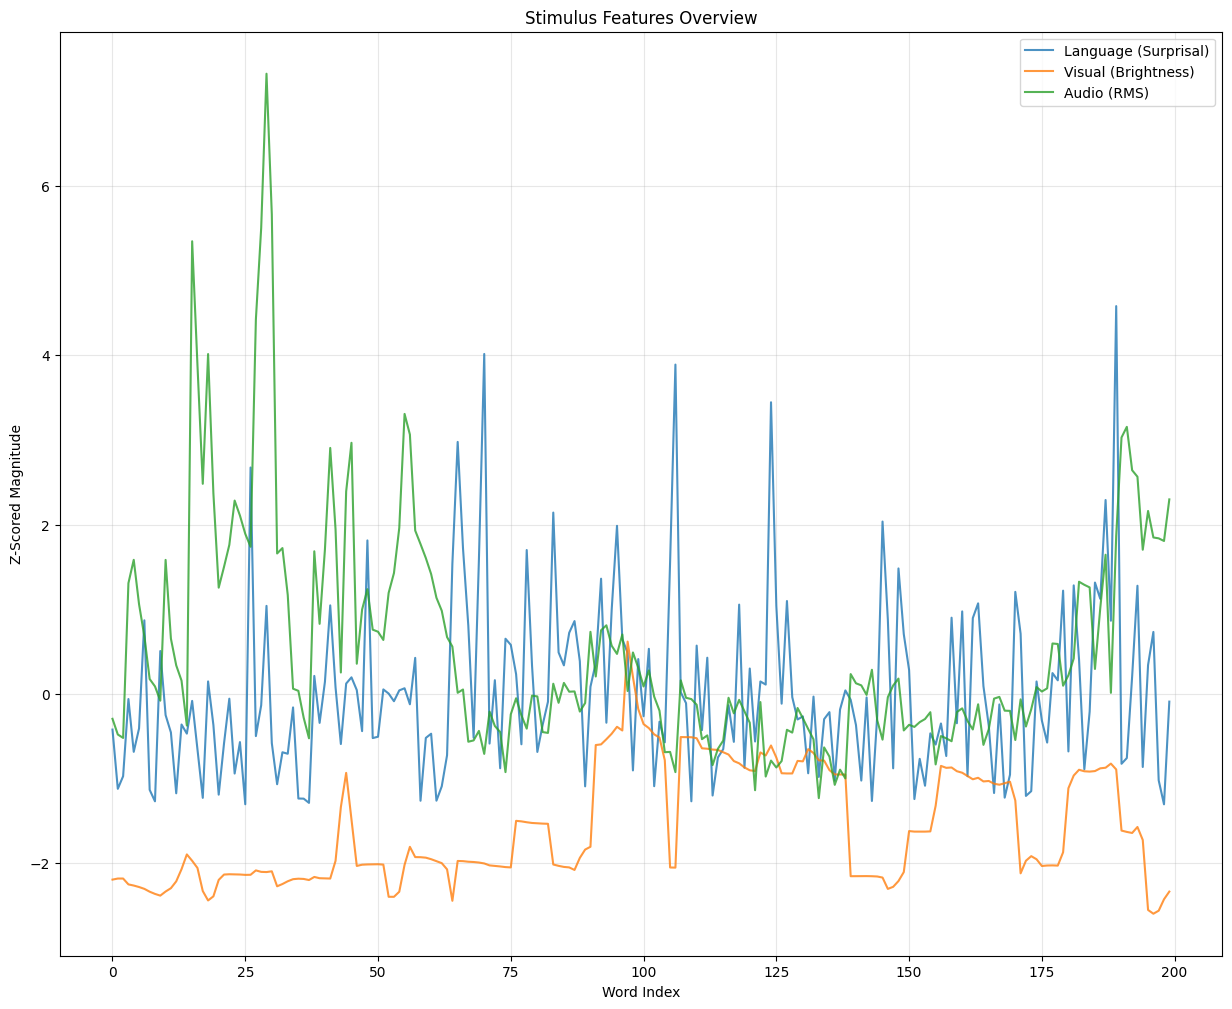

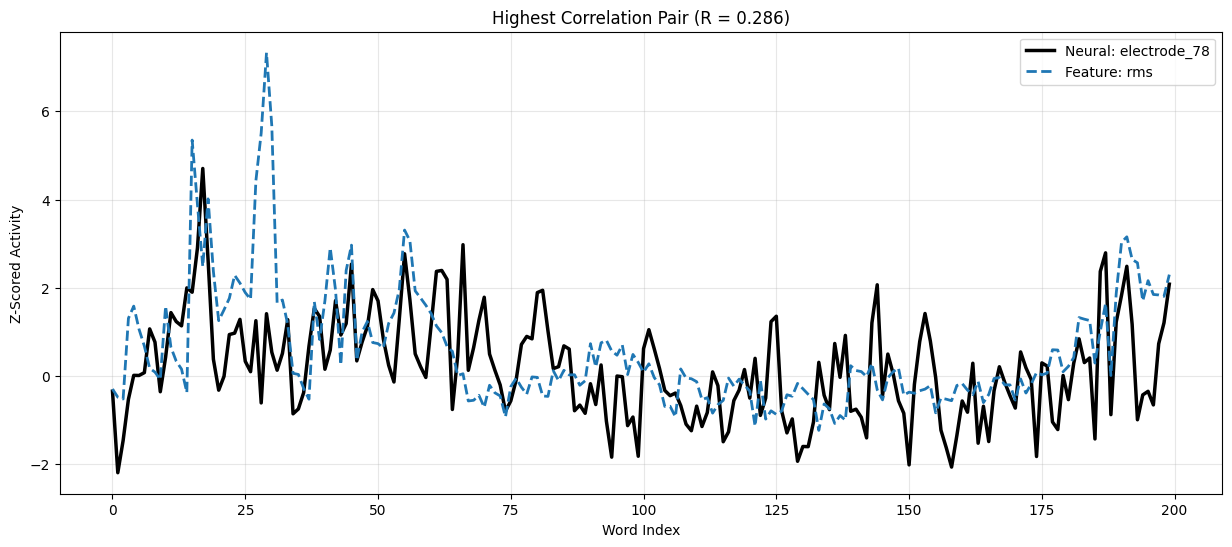

In [ ]:
pdf_path = os.path.join(root_dir, f"Analysis_Sub{sub_id}_CorrelationResults.pdf")

with PdfPages(pdf_path) as pdf:
    fig1, ax1 = plt.subplots(figsize=(15, 12))
    zoom = slice(100, 300) # 200 aligned words

    labels = {'gpt2_surprisal': 'Language (Surprisal)', 'mean_pixel_brightness': 'Visual (Brightness)', 'rms': 'Audio (RMS)'}

    PLOT_FEATURES = ['gpt2_surprisal', 'mean_pixel_brightness', 'rms']
    for feat in PLOT_FEATURES:
        if feat in words_df.columns:
            # Extract and z-score just this feature for plotting
            feat_data = words_df.loc[valid_mask, feat].values
            # Simple interpolation for NaNs in display
            feat_data = pd.Series(feat_data).interpolate().fillna(0).values
            feat_z = stats.zscore(feat_data)

            ax1.plot(feat_z[zoom], label=labels.get(feat, feat), linewidth=1.5, alpha=0.8)

    ax1.set_title("Stimulus Features Overview")
    ax1.set_xlabel("Word Index")
    ax1.set_ylabel("Z-Scored Magnitude")
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    pdf.savefig(fig1)
    plt.show()
    plt.close()

    # The Best Match
    fig2, ax2 = plt.subplots(figsize=(15, 6))

    ax2.plot(Y_z[zoom, best_elec_idx], label=f'Neural: {best_elec_name}', color='black', linewidth=2.5)
    ax2.plot(U_z[zoom, best_feat_idx], label=f'Feature: {best_feat_name}', linewidth=2, linestyle='--')

    ax2.set_title(f"Highest Correlation Pair (R = {best_corr_val:.3f})")
    ax2.set_xlabel("Word Index")
    ax2.set_ylabel("Z-Scored Activity")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    pdf.savefig(fig2)
    plt.show()
    plt.close()

## Training the Kalman Filter via EM

We use pykalman since I'va already implemented kalman filter and EM in the homework problem.

In [ ]:
!pip install pykalman

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.4/249.4 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 13.7 MB/s eta 0:00:00


In [ ]:
from pykalman import KalmanFilter
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


# Data Splitting
# We cannot shuffle timepoints (destroys physics/dynamics).
# Instead, we define a block in the middle for testing.
total_samples = Y.shape[0]
test_size = int(total_samples * 0.2)
test_start = int(total_samples * 0.4) # Test on the middle 20%
test_end = test_start + test_size

indices = np.arange(total_samples)
test_mask = (indices >= test_start) & (indices < test_end)
train_mask = ~test_mask

Y_train_full = Y[train_mask] # This creates a jump in time at the splice point,
                             # but it's better than random shuffling.
Y_test = Y[test_mask]
Y_train_stable = Y[:test_start] # This avoids the jump

print(f"Total samples: {total_samples}")
print(f"Training on: 0 to {test_start}")
print(f"Testing on:  {test_start} to {test_end}")

Total samples: 10118
Training on: 0 to 4047
Testing on:  4047 to 6070


Training...
Running inference on Test set...
------------------------------
FILTERED Results (Real-time):
  Mean MSE: 0.7337
  Mean Correlation: 0.3014
------------------------------
SMOOTHED Results (Post-hoc):
  Mean MSE: 0.7338
  Mean Correlation: 0.2970
------------------------------
Best Electrode: 9
  Filtered Corr: 0.9569
  Smoothed Corr: 0.9550


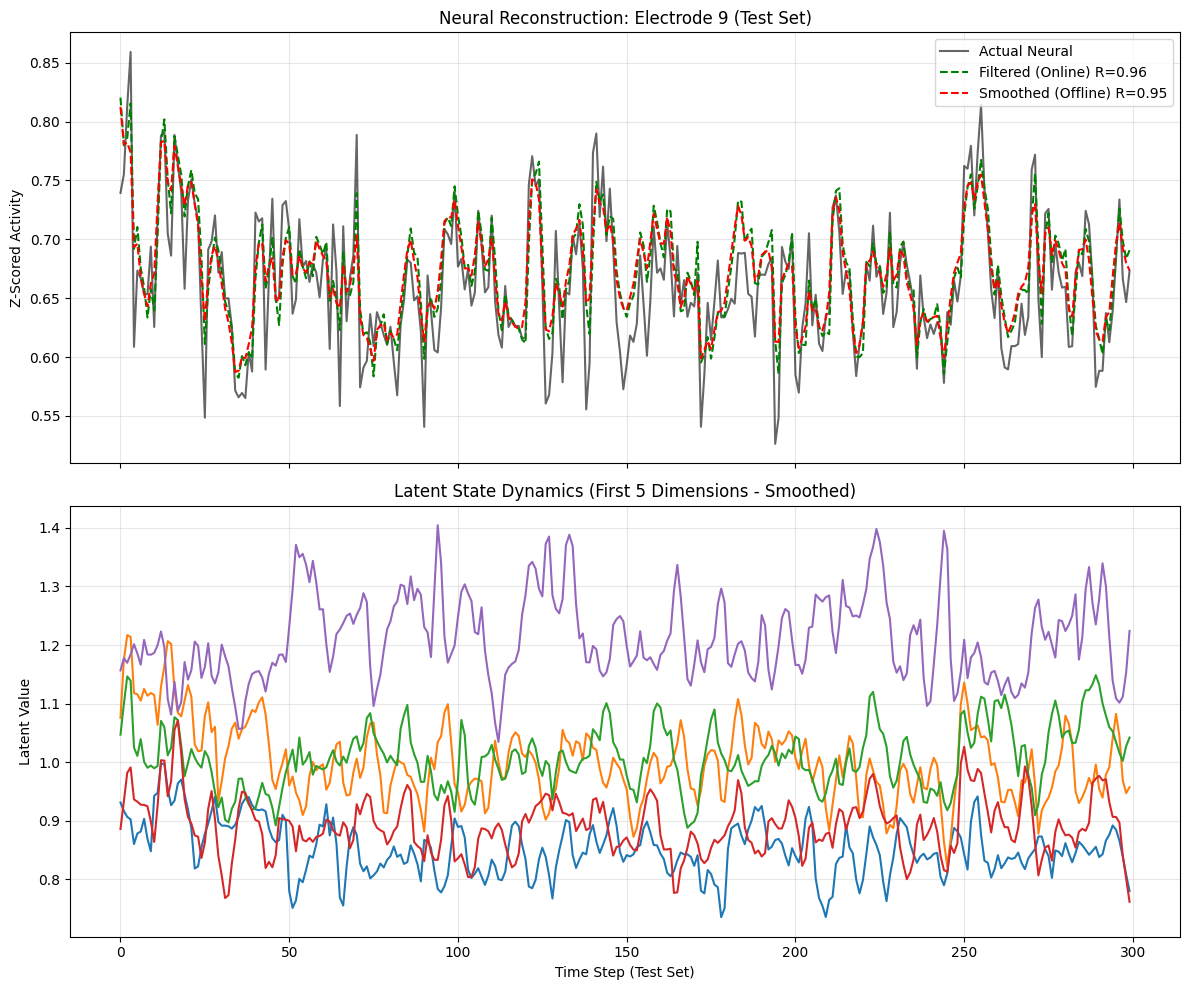

In [ ]:
n_dim_state = 10 # Latent dimensions
n_dim_obs = Y.shape[1] # Observed electrodes

print("Training...")
kf = KalmanFilter(n_dim_state=n_dim_state, n_dim_obs=n_dim_obs)
kf_trained = kf.em(Y_train_stable, n_iter=10)

print("Running inference on Test set...")
means_filtered, cov_filtered = kf_trained.filter(Y_test)
means_smoothed, cov_smoothed = kf_trained.smooth(Y_test)

# Reconstruct Neural Data (Y_pred = Latent * C.T + d)
# We need the observation matrix (C) and offset (d)
C = kf_trained.observation_matrices
d = kf_trained.observation_offsets
Y_pred_filtered = np.dot(means_filtered, C.T) + d
Y_pred_smoothed = np.dot(means_smoothed, C.T) + d

# Metrics
def get_correlations(y_true, y_pred):
    corrs = []
    for i in range(y_true.shape[1]):
        if np.std(y_true[:, i]) == 0 or np.std(y_pred[:, i]) == 0:
            c = 0.0
        else:
            c, _ = stats.pearsonr(y_true[:, i], y_pred[:, i])
            if np.isnan(c): c = 0.0
        corrs.append(c)
    return np.array(corrs)

corr_filt = get_correlations(Y_test, Y_pred_filtered)
corr_smooth = get_correlations(Y_test, Y_pred_smoothed)

# MSE
mse_filt = np.mean((Y_test - Y_pred_filtered) ** 2)
mse_smooth = np.mean((Y_test - Y_pred_smoothed) ** 2)

print("-" * 30)
print(f"FILTERED Results (Real-time):")
print(f"  Mean MSE: {mse_filt:.4f}")
print(f"  Mean Correlation: {np.mean(corr_filt):.4f}")
print("-" * 30)
print(f"SMOOTHED Results (Post-hoc):")
print(f"  Mean MSE: {mse_smooth:.4f}")
print(f"  Mean Correlation: {np.mean(corr_smooth):.4f}")
print("-" * 30)

# Identify best electrode based on Smoothed data
best_elec_idx = np.argmax(corr_smooth)
print(f"Best Electrode: {best_elec_idx}")
print(f"  Filtered Corr: {corr_filt[best_elec_idx]:.4f}")
print(f"  Smoothed Corr: {corr_smooth[best_elec_idx]:.4f}")

fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

time_steps = 300
t = np.arange(time_steps)

# Plot 1: Reconstructions
ax1 = axes[0]
ax1.plot(t, Y_test[:time_steps, best_elec_idx], 'k-', lw=1.5, alpha=0.6, label='Actual Neural')
ax1.plot(t, Y_pred_filtered[:time_steps, best_elec_idx], 'g--', lw=1.5, label=f'Filtered (Online) R={corr_filt[best_elec_idx]:.2f}')
ax1.plot(t, Y_pred_smoothed[:time_steps, best_elec_idx], 'r--', lw=1.5, label=f'Smoothed (Offline) R={corr_smooth[best_elec_idx]:.2f}')

ax1.set_title(f'Neural Reconstruction: Electrode {best_elec_idx} (Test Set)')
ax1.set_ylabel('Z-Scored Activity')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot 2: Latent States
ax2 = axes[1]
# We plot just the first 5 latent dimensions for clarity
ax2.plot(t, means_smoothed[:time_steps, :5])
ax2.set_title('Latent State Dynamics (First 5 Dimensions - Smoothed)')
ax2.set_ylabel('Latent Value')
ax2.set_xlabel('Time Step (Test Set)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('kalman_results.pdf')
plt.show()

## Histogram of Correlations

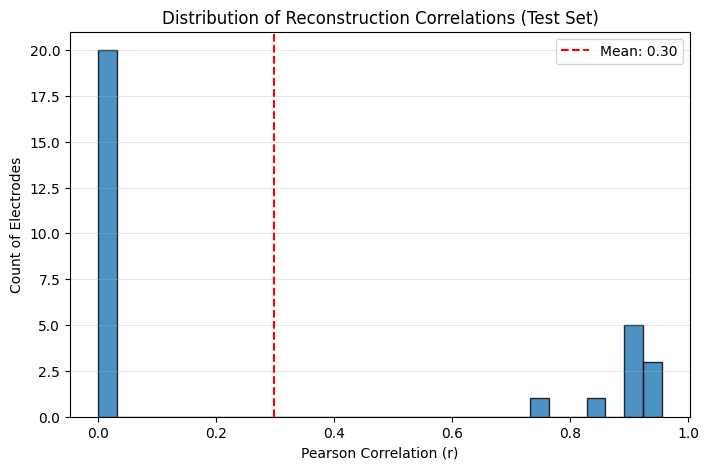

Histogram saved to /content/drive/MyDrive/braintreebank_data/correlation_hist.pdf


In [ ]:
plt.figure(figsize=(8, 5))
# We use the smoothed version
plt.hist(corr_smooth, bins=30, color='#1f77b4', edgecolor='black', alpha=0.8)
plt.axvline(np.mean(corr_smooth), color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {np.mean(corr_smooth):.2f}')

plt.title('Distribution of Reconstruction Correlations (Test Set)')
plt.xlabel('Pearson Correlation (r)')
plt.ylabel('Count of Electrodes')
plt.legend()
plt.grid(axis='y', alpha=0.3)

hist_path = os.path.join(root_dir, 'correlation_hist.pdf')
plt.savefig(hist_path)
plt.show()

## Brain Visualization
Based on the brain tree bank quickstart notebook.

Plotting 25 electrodes on brain map...


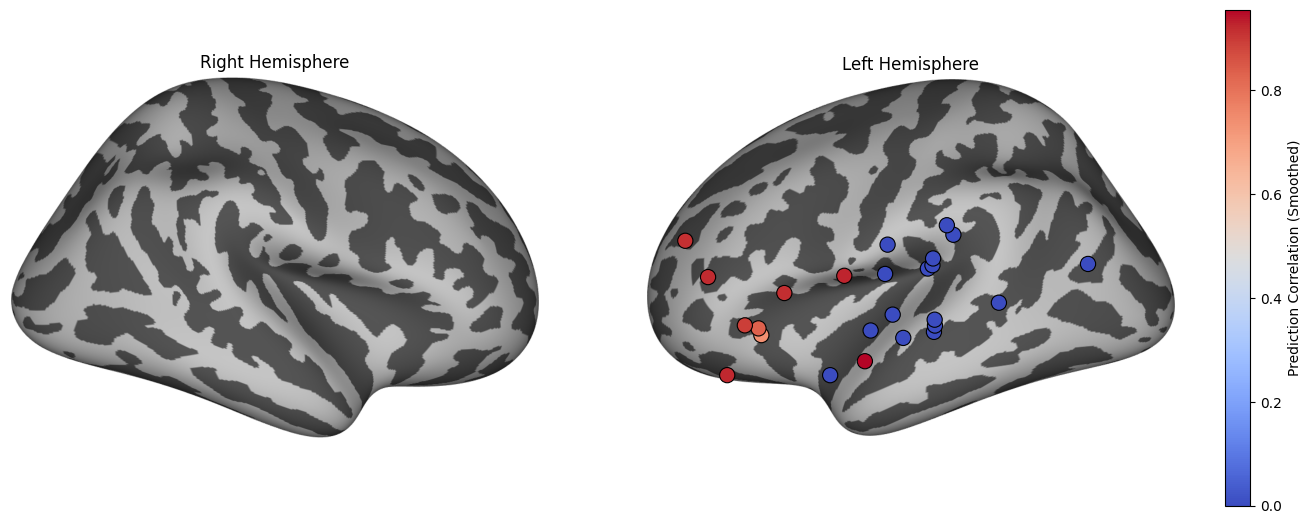

In [ ]:
base_path = os.path.join(root_dir, 'localization')
left_hem_path = os.path.join(base_path, 'left_hem_clean.png')
right_hem_path = os.path.join(base_path, 'right_hem_clean.png')
coords_path = os.path.join(base_path, 'elec_coords_full.csv')
labels_path = os.path.join(root_dir, f'electrode_labels/sub_{sub_id}/electrode_labels.json')

left_img = plt.imread(left_hem_path)
right_img = plt.imread(right_hem_path)

coords_df = pd.read_csv(coords_path)
with open(labels_path, 'r') as f:
    labels_data = json.load(f)

plot_data = []

# We iterate through the electrodes we actually analyzed (target_keys)
# target_keys matches the columns of Y and corr_smooth
for i, key in enumerate(target_keys):
    # key format is 'electrode_123'
    elec_idx = int(key.split('_')[1])

    # Get Label (like 'T2aA12')
    if isinstance(labels_data, list):
        label = labels_data[elec_idx] if elec_idx < len(labels_data) else None
    else:
        label = labels_data.get(str(elec_idx), None)

    if label:
        elec_id = f"sub_{sub_id}-{label}"

        plot_data.append({
            'ID': elec_id,
            'Correlation': corr_smooth[i], # The color value
            'Label': label
        })

plot_df = pd.DataFrame(plot_data)
merged_df = pd.merge(plot_df, coords_df, on='ID', how='inner')

print(f"Plotting {len(merged_df)} electrodes on brain map...")

# Coordinate Scaling (3D -> 2D Image)
# Standard bounds for this dataset structure (from braintree bank codebase)
matlab_xlim = (-108.0278, 108.0278)
matlab_ylim = (-72.9774, 72.9774)

x_scale = left_img.shape[1] / (matlab_xlim[1] - matlab_xlim[0])
y_scale_l = left_img.shape[0] / (matlab_ylim[1] - matlab_ylim[0])
y_scale_r = right_img.shape[0] / (matlab_ylim[1] - matlab_ylim[0])

def scale_coord(val, s, d):
    return -(val - d) * s

merged_df['plot_x'] = 0.0
merged_df['plot_y'] = 0.0

mask_l = merged_df['Hemisphere'] == 1
merged_df.loc[mask_l, 'plot_x'] = merged_df.loc[mask_l, 'X'].apply(lambda x: scale_coord(x, x_scale, matlab_xlim[1]))
merged_df.loc[mask_l, 'plot_y'] = merged_df.loc[mask_l, 'Y'].apply(lambda y: scale_coord(y, y_scale_l, matlab_ylim[1]))

mask_r = merged_df['Hemisphere'] == 0
merged_df.loc[mask_r, 'plot_x'] = merged_df.loc[mask_r, 'X'].apply(lambda x: -scale_coord(x, x_scale, matlab_xlim[0]))
merged_df.loc[mask_r, 'plot_y'] = merged_df.loc[mask_r, 'Y'].apply(lambda y: scale_coord(y, y_scale_r, matlab_ylim[1]))

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].imshow(right_img)
axes[0].axis('off')
axes[0].set_title('Right Hemisphere')
if mask_r.any():
    sc0 = axes[0].scatter(
        merged_df[mask_r]['plot_x'],
        merged_df[mask_r]['plot_y'],
        c=merged_df[mask_r]['Correlation'],
        cmap='coolwarm', vmin=0, vmax=max(0.1, np.max(corr_smooth)),
        s=120, edgecolors='k', linewidth=0.8
    )

axes[1].imshow(left_img)
axes[1].axis('off')
axes[1].set_title('Left Hemisphere')
if mask_l.any():
    sc1 = axes[1].scatter(
        merged_df[mask_l]['plot_x'],
        merged_df[mask_l]['plot_y'],
        c=merged_df[mask_l]['Correlation'],
        cmap='coolwarm', vmin=0, vmax=max(0.1, np.max(corr_smooth)),
        s=120, edgecolors='k', linewidth=0.8
    )

cbar = fig.colorbar(sc1 if mask_l.any() else sc0, ax=axes.ravel().tolist(), fraction=0.02, pad=0.04)
cbar.set_label('Prediction Correlation (Smoothed)')

brain_pdf_path = os.path.join(root_dir, 'brain_correlation_map.pdf')
plt.savefig(brain_pdf_path, dpi=300)
plt.show()

## PSID

In [ ]:
!pip install PSID --upgrade

In [ ]:
from matplotlib.ticker import MaxNLocator
from scipy import stats
import PSID
from PSID.evaluation import evalPrediction

total_samples = Y.shape[0]
test_start = int(total_samples * 0.4)
test_end = int(total_samples * 0.6)

y_train_raw = Y[:test_start]
y_test_raw  = Y[test_start:test_end]
z_train_raw = U[:test_start]
z_test_raw  = U[test_start:test_end]

yTrain = np.nan_to_num(stats.zscore(y_train_raw, axis=0))
yTest  = np.nan_to_num(stats.zscore(y_test_raw, axis=0))
zTrain = np.nan_to_num(stats.zscore(z_train_raw, axis=0))
zTest  = np.nan_to_num(stats.zscore(z_test_raw, axis=0))


def run_psid_analysis(y_train, y_test, z_train, z_test, label_obs, label_beh, save_prefix):
    i_horizon = 10

    max_dim_z = z_train.shape[1] * i_horizon
    max_dim_y = y_train.shape[1] * i_horizon
    max_possible_dim = min(15, min(max_dim_z, max_dim_y))

    dims = range(2, max_possible_dim + 1)

    results = {
        'dims': list(dims),
        'psid_beh': [], 'psid_neu': [],
        'sid_beh': [],  'sid_neu': []
    }

    print(f"\nRunning: {label_obs} -> {label_beh} (Max Dim: {max_possible_dim})")

    for nx in dims:
        # PSID (Half Prioritized)
        # We set n1 = nx//2
        psid_model = PSID.PSID(y_train, z_train, nx=nx, n1=nx//2, i=i_horizon)
        zPred_p, yPred_p, _ = psid_model.predict(y_test)

        results['psid_beh'].append(np.mean(evalPrediction(z_test, zPred_p, "R2")))
        results['psid_neu'].append(np.mean(evalPrediction(y_test, yPred_p, "R2")))

        # Naive
        # We set n1 = 0
        naive_model = PSID.PSID(y_train, z_train, nx=nx, n1=0, i=i_horizon)
        zPred_s, yPred_s, _ = naive_model.predict(y_test)

        results['sid_beh'].append(np.mean(evalPrediction(z_test, zPred_s, "R2")))
        results['sid_neu'].append(np.mean(evalPrediction(y_test, yPred_s, "R2")))

    # Eigenvalue Visualization (From PSID tutorial on Github https://github.com/ShanechiLab/PyPSID/tree/main/source/PSID/example)
    # We pick nx=10, n1=5 to see both types
    viz_nx = min(10, max_possible_dim)
    viz_n1 = viz_nx // 2


    viz_model = PSID.PSID(y_train, z_train, nx=viz_nx, n1=viz_n1, i=i_horizon)
    A_mat = viz_model.A
    eigs_rel = np.linalg.eigvals(A_mat[:viz_n1, :viz_n1])
    eigs_irr = np.linalg.eigvals(A_mat[viz_n1:, viz_n1:])

    fig, axes = plt.subplots(1, 2, figsize=(13, 5))

    # Behavior Decoding
    # axes[0].plot(results['dims'], results['psid_beh'], 'b-o', label='PSID (n1=nx//2)')
    # axes[0].plot(results['dims'], results['sid_beh'], 'r--s', label='Naive (n1=0)')
    # axes[0].set_ylabel(f'Decoding $R^2$ ({label_beh})')
    # axes[0].set_xlabel(f'Number of Latent Dimensions')
    # axes[0].set_title('Behavior Decoding')
    # axes[0].legend()
    # axes[0].grid(True, alpha=0.3)

    # Neural Self-Reconstruction
    axes[0].plot(results['dims'], results['psid_neu'], 'b-o', label='PSID (n1=nx//2)')
    axes[0].plot(results['dims'], results['sid_neu'], 'r--s', label='Naive (n1=0)')
    axes[0].set_xlabel(f'Number of Latent Dimensions')
    axes[0].set_ylabel(f'Reconstruction $R^2$ ({label_obs})')
    axes[0].set_title('Neural Self-Prediction')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Eigenvalues
    theta = np.linspace(0, 2*np.pi, 100)
    axes[1].plot(np.cos(theta), np.sin(theta), 'k--', alpha=0.2)
    axes[1].scatter(np.real(eigs_rel), np.imag(eigs_rel), c='green', marker='o', s=60, label='Relevant')
    axes[1].scatter(np.real(eigs_irr), np.imag(eigs_irr), c='red', marker='x', s=60, label='Irrelevant')
    axes[1].set_title(f'Eigenvalues (Model nx={viz_nx}, n1={viz_n1})')
    axes[1].axis('equal')
    axes[1].legend(loc='lower left')

    plt.suptitle(f"PSID Analysis: {label_obs} $\\to$ {label_beh}", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f'psid_{label_obs}_{label_beh}.pdf')
    plt.show()


Running: Neural -> Features (Max Dim: 15)


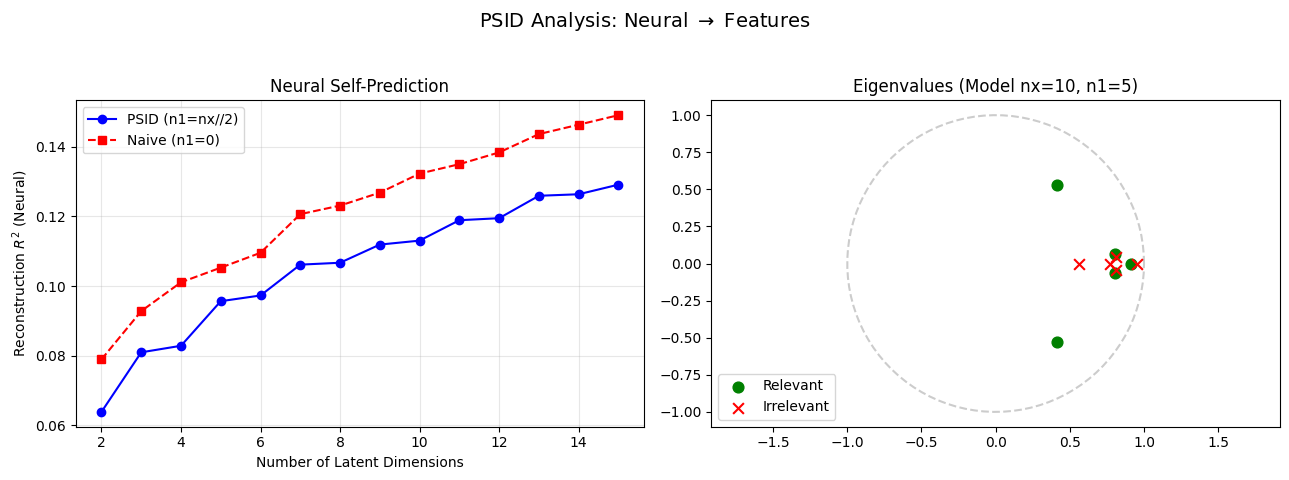

In [ ]:
# Neural -> Movie Features
run_psid_analysis(yTrain, yTest, zTrain, zTest, "Neural", "Features", "Forward")


Running: Features -> Neural (Max Dim: 15)


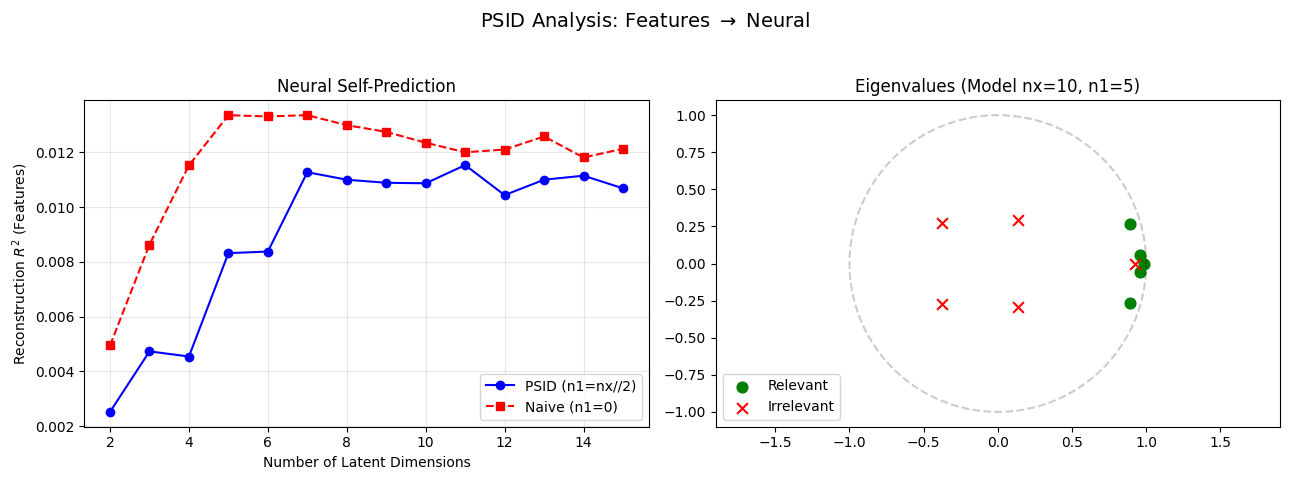

In [ ]:
# Movie Features -> Neural
run_psid_analysis(zTrain, zTest, yTrain, yTest, "Features", "Neural", "Reverse")

## Sentence Transformers

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA

# model = SentenceTransformer('all-MiniLM-L6-v2')
model = SentenceTransformer('all-mpnet-base-v2')

words_df_clean = words_df[valid_mask].reset_index(drop=True)
sentences = words_df_clean['text'].astype(str).tolist()

print(f"Generating embeddings for {len(sentences)} words...")
embeddings = model.encode(sentences)

# Reduce to 20 dimensions with PCA
pca = PCA(n_components=20)
U_pca = pca.fit_transform(embeddings)
U = stats.zscore(U_pca, axis=0)

print(f"Existing Neural Matrix Y shape: {Y.shape}")
print(f"New LLM Input Matrix U_llm shape: {U.shape}")

Generating embeddings for 10118 words...
Existing Neural Matrix Y shape: (10118, 30)
New LLM Input Matrix U_llm shape: (10118, 20)


Splitting Data (Total samples: 10118)
  Training Block: 0 -> 4047
  Testing Block:  4047 -> 6070
Normalizing data (Z-scoring)...
  Neural Train: (4047, 30), Test: (2023, 30)
  LLM Features Train: (4047, 20), Test: (2023, 20)

Running: Neural Data -> LLM Embeddings (Max Dim: 15)


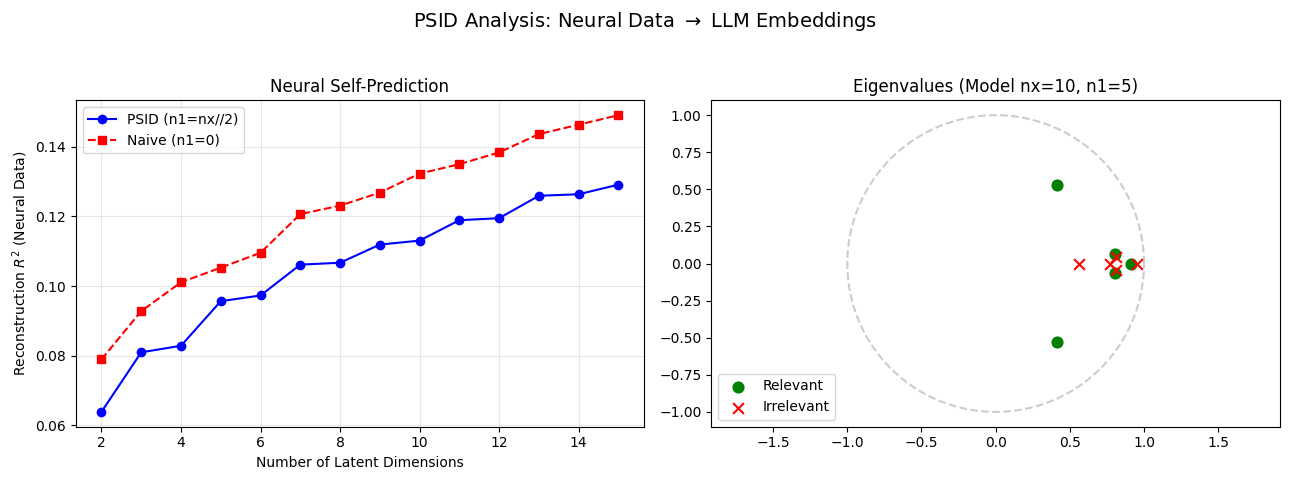

In [ ]:
total_samples = Y.shape[0]
test_start = int(total_samples * 0.4)
test_end = int(total_samples * 0.6)

print(f"Splitting Data (Total samples: {total_samples})")
print(f"  Training Block: 0 -> {test_start}")
print(f"  Testing Block:  {test_start} -> {test_end}")

y_train_raw = Y[:test_start]
y_test_raw  = Y[test_start:test_end]
z_train_raw = U[:test_start]
z_test_raw  = U[test_start:test_end]

print("Normalizing data (Z-scoring)...")
y_train = np.nan_to_num(stats.zscore(y_train_raw, axis=0))
y_test  = np.nan_to_num(stats.zscore(y_test_raw, axis=0))
z_train = np.nan_to_num(stats.zscore(z_train_raw, axis=0))
z_test  = np.nan_to_num(stats.zscore(z_test_raw, axis=0))

print(f"  Neural Train: {y_train.shape}, Test: {y_test.shape}")
print(f"  LLM Features Train: {z_train.shape}, Test: {z_test.shape}")

run_psid_analysis(
    y_train=y_train, y_test=y_test,
    z_train=z_train, z_test=z_test,
    label_obs="Neural Data",
    label_beh="LLM Embeddings",
    save_prefix="Forward_LLM"
)


Running: LLM Embeddings -> Neural Data (Max Dim: 15)


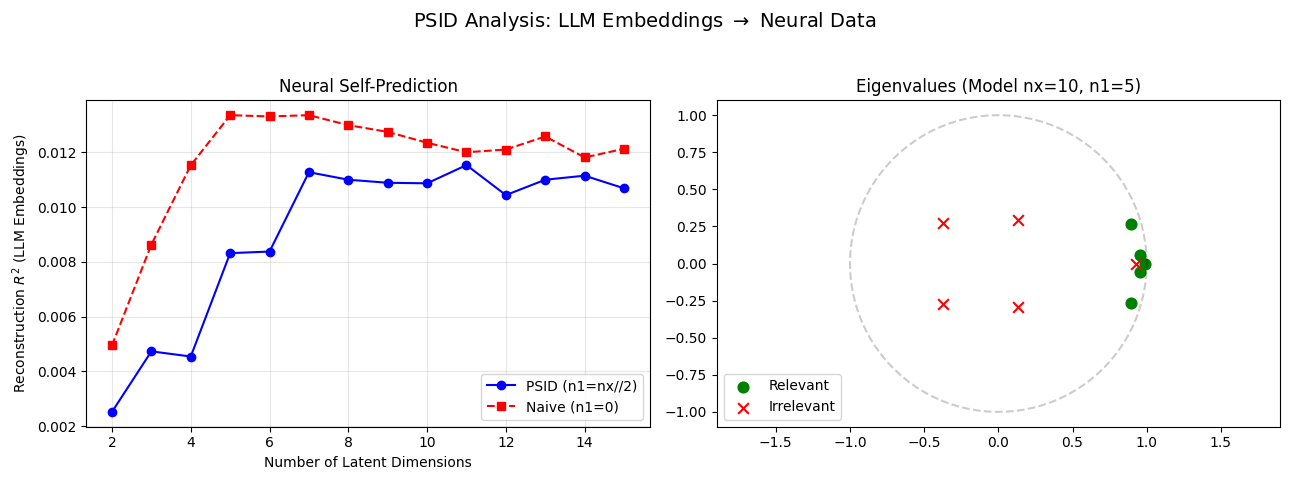

In [ ]:
run_psid_analysis(
    y_train=z_train, y_test=z_test,
    z_train=y_train, z_test=y_test,
    label_obs="LLM Embeddings",
    label_beh="Neural Data",
    save_prefix="Reverse_LLM"
)